Hello, and welcome to this tutorial on simulating circuit noise in Tequila! In this tutorial, we will briefly detail what quantum noise is, its mathematical modeling, and how specific popular simulation packages handle noisy simulation, before diving in to building Tequila `NoiseModel`s and applying them to sampling different circuits.

# <center> What is noise?</center>

In case you need a quick refresher: Real quantum systems undergo the effects of noise, a catch-all term for 'anything the user didn't ask the computer to do'. Such noise can be caused by a number of physical processes, including but not limited to: 

 - **Thermal fluctuations**
 - **Interaction with the environment**
 - **Uncontrolled interaction between qubits (cross-talk)**
 - **Imperfections in gate implementation**
 


# <center> How is noise represented mathematically?</center>


Commonly, the effects of noise on quantum systems are treated as the evolution of the system's density matrix under Krauss maps. Krauss maps are mappings of the form $ A: \rho \rightarrow \rho' = \sum_{i} A_i \rho A_{i}^{\dagger}$, where $\sum_{i} A_i  A_{i}^{\dagger} = I$. These Krauss maps are parametrized, in general by probabilities.

For example, bit flip noise -- which takes qubits from the 0 to the 1 state and vice versa-- is a krauss map with two operators, and a single probabilistic parameter, p. The operators are:
$$A_0 = \sqrt{1-p} I,  A_1 = \sqrt{p} X$$
**Note that the square root is present, so that bit flip map is:**
$$ A_{bf}(p): \rho \rightarrow (1-p) * I\rho I + p * X\rho X$$
other noise operations may be defined similarly.

**Note that such krauss operators may only affect subsystems of the system;** one can have a single qubit undergo bit-flip noise in an 8 qubit state. In such cases, the krauss maps are merely the 1-qubit maps tensored with the identity on all other qubits. Multi-qubit krauss operators will involve tensor products of single qubit krauss operators.

For example, the 2-qubit bit flip krauss map has 4 operators:
$$A_{00}=(1-p)I\otimes I, A_{01}=\sqrt{p-p^2}I\otimes X,A_{10}=\sqrt{p-p^2}X \otimes I,A_{11}=pX\otimes X$$
Which are just all the tensor products of $A_{0}$ and $A_{1}$.

# <center> 3. How is noise simulated? </center>

Different simulation packages handle noise in radically different ways.

*Cirq* and *Qulacs*, for example, use noise channels, parametrized operations which are inserted into circuits the same way regular, unitary gates are. 

*Pyquil* asks its users to define noisy gate operations, and then instantiate those. 

*Qiskit*, meanwhile, simply takes a dictionary-like object as an argument to its simulator, and applies the noise on the user-chosen gates.

In tequila, we try to hew toward making users write as few lines of code as possible. We therefore implement a simple framework for the application of noise, meant to be compatible with all our supported platforms. To do this, we make a few assumptions:

1. If noise is present, any gate may be affected by noise.
2. The noise that affects 1..k..n-qubit gates is independent of the noise on 1...k-1,k+1...n qubit gates.
3. Noise probabilities are independent of position in the circuit.
4. The number of qubits involved in a gate, not the operation performed, dictates what noises may occur.



# <center>  Noise in Tequila: Overview </center>

noise in Tequila is centered upon the `NoiseModel` class, itself used to store and combine `QuantumNoise` objects. 
Each `QuantumNoise` internally designates what operation it will perform, with what probability (or probabilities), and on how many qubits. Only at the time of translation to a backend -- or in the case of *Qiskit*, at time of simulation -- do`NoiseModel`s and simulateables -- circuits, ExpectationValues, Objectives -- interact.

Tequila at present supports six common quantum noise operations, all of which can at present be employed by all the noise-supporting simulation backgrounds. These six operations are:

1. Bit flips, a probabilistic application of pauli X;
2. Phase flips, a probablistic application of pauli Z;
3. Amplitude damps, which take qubits in state |1> to |0>;
4. Phase damps, which are a different formalization of the phase flip;
5. Phase-Amplitude damps, which simultaneously perform said operations;
6. (Symmetric) depolarizing, which (equi)probabilistically performs pauli X, Y, and Z.

in Tequila, custom members of the `QuantumNoise` class are not possible, and so they should be initialized by the constructor function for each supported channel, which creates a `NoiseModel` containing one operation. all six of which are shown in the import statement below.

`NoiseModel`s combine with eachother through addition, creating a new `NoiseModel` with all the operations of the two summands. Note that in those simulators which employ noise channels, the order of the noises in the noise model will dictate the order of application in the circuit; users should be mindful of this.

To use a `NoiseModel` to apply noise, one may provide a noise model to the *tq.compile*, *tq.simulate*, and optimization calls like *tq.minimize*, through the keyword `noise=my_noise_model`. Noise is only supported when sampling; if in the above functions the keyword *samples* is `None` (defaullt), noise cannot function.

additionally, Tequila supports the use of device-noise-emulation for those backends which allow the emulation of specific real devices. If in compilation, simulation, or optimization, emulated backends have been selected (such as 'fake_vigo', for IBMQ), the known noise of this device may be employed. In these cases, the keyword assignment *noise='device'* should be used, if these known noise models are desired.



In [1]:
### first, we import tequila!
import tequila as tq
from tequila.circuit.noise import BitFlip,PhaseFlip,AmplitudeDamp,PhaseDamp,PhaseAmplitudeDamp,DepolarizingError

We will first examine bit flip noise on a simple circuit with a simple Hamiltonian.

In [33]:
H=tq.paulis.Qm(1) ### this hamiltonian is 0 for a qubit that is 0, and 1 for a qubit that is 1.
U=tq.gates.X(0)+tq.gates.CNOT(0,1)
O1=tq.ExpectationValue(U=U,H=H)

print('simulating: ',H)
print('acting on: ')
tq.draw(U)

simulating:  +0.5000-0.5000Z(1)
acting on: 
0: ───X───@───
          │
1: ───────X───


Say that we wanted a noise model where 1-qubit gates and 2-qubit gates undergo bit flips, but with different probabilities.

In [3]:
bf_1=BitFlip(p=0.1,level=1)
bf_2=BitFlip(p=0.3,level=2)

 `NoiseModel` objects, like those initialized above, can be combined into new `NoiseModel`s by simple addition.

In [4]:
my_nm=bf_1+bf_2
print('applying:',my_nm)

applying: NoiseModel with: 
bit flip on 1 qubit gates, probs = [0.1],
bit flip on 2 qubit gates, probs = [0.3],



we will now sample our `Objective` O1, both with and without noise.

In [35]:
E=tq.simulate(O1)
### noise models are fed to tequila functions with the noise keyword.
E_noisy=tq.simulate(O1,samples=5000,noise=my_nm)
print('Without noise, E =',E)
print('With noise, E =',E_noisy)

Without noise, E = 1.0
With noise, E = 0.6664


**Because noise is stochastic, results may vary wildly if the number of samples is low.**

In [36]:
for i in range(1,11):
    print('round',i,'sampling with 5 samples, E = ', tq.simulate(O1,samples=5,noise=my_nm))


round 1 sampling with 5 samples, E =  0.8
round 2 sampling with 5 samples, E =  1.0
round 3 sampling with 5 samples, E =  0.6
round 4 sampling with 5 samples, E =  0.6
round 5 sampling with 5 samples, E =  0.4
round 6 sampling with 5 samples, E =  0.2
round 7 sampling with 5 samples, E =  0.8
round 8 sampling with 5 samples, E =  0.4
round 9 sampling with 5 samples, E =  0.8
round 10 sampling with 5 samples, E =  0.6


Note that the *BitFlip* functions returned applicable `NoiseModel`s in their own right:


In [23]:
E_1_only=tq.simulate(O1,samples=1000,noise=bf_1)
print('With 1-qubit noise only, E =',E_1_only)
E_2_only=tq.simulate(O1,samples=1000,noise=bf_2)
print('With 2-qubit noise only, E =',E_2_only)


With 1-qubit noise only, E = 0.9139999999999999
With 2-qubit noise only, E = 0.69


Below, we demonstrate the effects of the ordering of the noise operations applied. 


In [26]:
amp=AmplitudeDamp(0.3,1)
bit=BitFlip(0.4,1)
forward=amp+bit
backward=bit+amp

H = tq.paulis.Z(0)
U = tq.gates.X(target=0)
O = tq.ExpectationValue(U=U, H=H)

E_1 = tq.simulate(O,samples=100000,noise=forward)
E_2 = tq.simulate(O,samples=100000,noise=backward)
print('amplitude damping before bit flip leads to E = ',E_1)
print('amplitude damping after bit flip leads to E = ',E_2)

WARNING - WARNING: all-qubit error already exists for instruction "x", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "y", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "z", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "u3", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "u1", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "u2", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "h", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "x", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruction "y", composing with additional error.
WARNING - WARNING: all-qubit error already exists for instruc

amplitude damping before bit flip leads to E =  -0.08186
amplitude damping after bit flip leads to E =  0.15744


Tequila will *always* attempt to apply noise to the circuit *in the order each noise was added to the noise model*. Some backends have behavior which is harder to control than others, but in general, this order will be preserved.

Below, we will optimize a noisy circuit.

In [37]:

import numpy as np

Consider the 1-qubit expectation value, $<0|U^{\dagger}\hat{Y}U|0>$, with $U=H Rz(\theta) H $. In the absence of noise, this expectation value just yields $Sin(\theta)$. This circuit therefore has a minimum at $\theta = -\pi$. We can minimize this circuit under phase flip noise -- which is probabilistic application of pauli Z -- and see what happens!

optimizing expectation value with phase flip probability 0.08991331275688234.


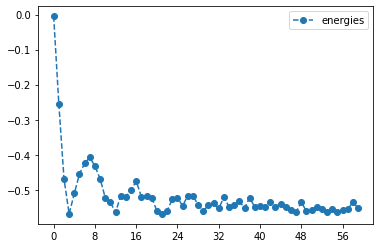

In [42]:
U=tq.gates.H(0) +tq.gates.Rz('a',0)+tq.gates.H(0)
H=tq.paulis.Y(0)
O=tq.ExpectationValue(U=U,H=H)

### we pick a random, small probability to apply noise
p=np.random.uniform(0,.1)
NM=PhaseFlip(p,1)

print('optimizing expectation value with phase flip probability {}.'.format(str(p)))
result=tq.minimize(objective=O,lr=0.5,maxiter=60,initial_values={'a':np.pi},method='adam',samples=5000,noise=NM,silent=True)

result.history.plot()

The final energy is not -1.0, because the application of noise leads the expected output to be $(-1+2*p)^{3} Sin(\theta)$. One sees that this is approximately the value reached by minimizing $\theta$. Because the number of samples is not infinite, the 'expected' best energy may be exceeded:

In [43]:
out=result.energy
best=((-1+2*p)**3)*np.sin(np.pi/2)
print('best energy: ',out)
print('expected best ',best)

best energy:  -0.5688
expected best  -0.5517178049632779


## This concludes our brief tutorial on Noise. Stay tuned (and up to date) for more exciting noise features in the future!